# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Deploying k-NN model on AWS



# Import modules
<hr style = "border:2px solid black" ></hr>

In [77]:
import boto3
from io import BytesIO
import joblib
import requests
import json
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Deploying a ML model to AWS
<hr style = "border:2px solid black" ></hr>


- As shown in the image below there are 3 resource infrastructure that will need to be deployed to support our lambda function deployment:
    - **S3** Bucket to store data.
    - **API gateway** to manage HTTP requests.
    - **Lambda function** containing the predictive logic.



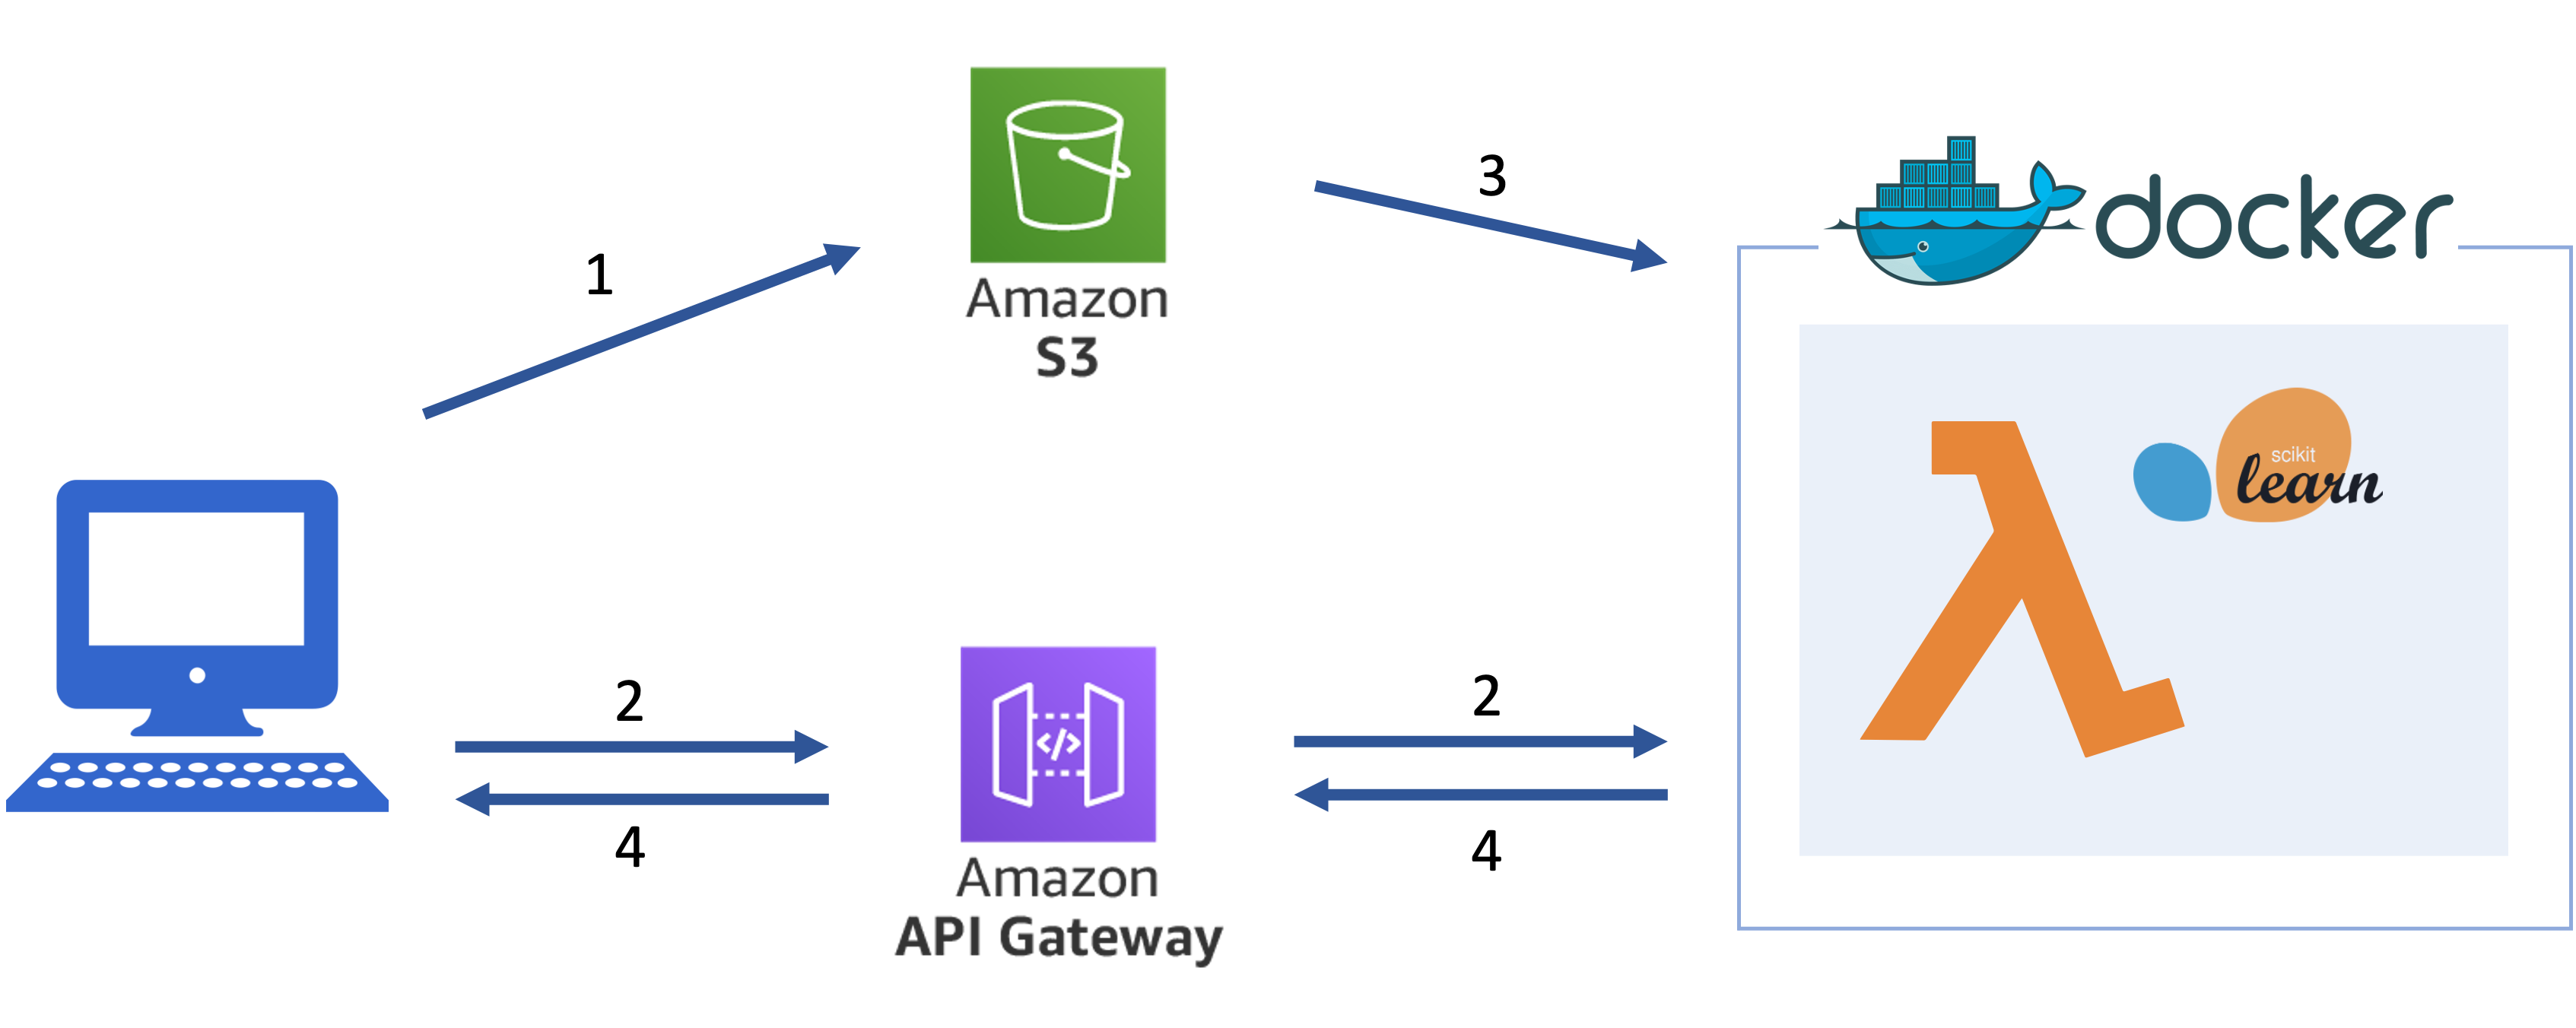

# What is SAM?
<hr style = "border:2px solid black" ></hr>


- SAM stands for Severless Application Model. 
    
- AWS SAM is an open source framework used to build serverless applications. It is a tool that streamlines the build process of serverless architecture by providing simple syntax to deploy functions, APIs or databases on AWS. SAM is a platform that unifies all the tools you need to rapidly deploy serverless applications all within a YAML configuration file.

- There are other options such as [serverless](https://www.serverless.com/) which is a great option. Serverless has the added advantage of being a universal cloud interface (AWS, Azure, Google Cloud) for increased versatility.



# Read-in dataset
<hr style = "border:2px solid black" ></hr>

In [22]:
# Load data
mnist = fetch_openml("mnist_784", version=1)

# Randomly sample 20000 rows from the original dataset
mnist_data = (
    mnist
    .data
    .sample(n=20000, random_state=42, axis=0, replace=False)
)

# Slice target by the same row sampling
target = (
    mnist
    .target
    .loc[mnist_data.index].astype('uint8')
)

In [25]:
# Split data to training and test set
train_features, test_features, train_target, test_target = train_test_split(
    mnist_data, target, test_size=0.2, random_state=42
)

# AWS S3 bucket
<hr style = "border:2px solid black" ></hr>


- It is assumed that you have locally download and configure your AWS CLI **already**.
- The S3 bucket will host our test_features data set which we can call in our lambda function to perform a prediction.



In [2]:
def create_bucket(region: str, bucket_name: str) -> dict:

    s3 = boto3.client('s3')
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint': region
        }
    )
    return response

In [3]:
region = 'eu-west-2'
bucket_name = 's3-buckets-knn-mnist'
create_bucket(region, bucket_name)

{'ResponseMetadata': {'RequestId': 'N4HXQ0Y2X25QZ3RH',
  'HostId': 'ECF5l9O/hgiVC+iE3S4gmQsYoA9LyF5IZToXxyodGV9VwSN1z4e9hF/lm4CVyDCHlbhctc3mcDs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ECF5l9O/hgiVC+iE3S4gmQsYoA9LyF5IZToXxyodGV9VwSN1z4e9hF/lm4CVyDCHlbhctc3mcDs=',
   'x-amz-request-id': 'N4HXQ0Y2X25QZ3RH',
   'date': 'Sat, 26 Mar 2022 10:26:38 GMT',
   'location': 'http://s3-buckets-knn-mnist.s3.amazonaws.com/',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': 'http://s3-buckets-knn-mnist.s3.amazonaws.com/'}


- To save an object currently in our workspace, we will be making use of BytesIO function from the io library. This will enable us to temporary store the test_features data set in a file object. This file object can be uploaded onto a S3 bucket by calling the `.upload_fileobj` function.

- The bucket variable defines the destination S3 bucket and the key variable will define the file path in the bucket. 

- The `bucket` and `key` variables will form part of the data payload in the POST HTTP request to our lambda function.



In [52]:
def UploadToS3(data, bucket: str, key: str):

    with BytesIO() as f:
        joblib.dump(data, f)
        f.seek(0)
        (
            boto3
            .client('s3')
            .upload_fileobj(Bucket=bucket, Key=key, Fileobj=f)
        )

In [1]:
!ls validation

test_features.joblib


In [54]:
test_features = joblib.load('validation/test_features.joblib')

In [55]:
key = 'validation/test_features.joblib'
UploadToS3(test_features, bucket_name, key)


- We can check if the objects have been uploaded with the helper function below. `list_s3_objects` will list all objects in the defined bucket.
- Once this completed you can check what is the bucket also by logging into you AWS webpage. 



In [56]:
def listS3Objects(bucket: str) -> list:

    # Connect to s3 resource
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    # List all object keys in s3 bucket
    obj_list = [object_summary.key for object_summary in my_bucket.objects.all()]
    return obj_list

In [57]:
listS3Objects(bucket_name)

['validation/test_features.joblib']

# Deploy lambda function with SAM locally
<hr style = "border:2px solid black" ></hr>


- Build a Docker image called `aws_knn_mnist`: `docker build . -t aws_knn_mnist`
- Use the docker GIU to run the docker image
- Navigate to the project directory and build the application in SAM: `sam build -t template_no_auth.yaml`
- Locally deploy the dockerised lambda function: `sam local start-api`
- Copy and past this: `http://127.0.0.1:3000/predict`. Your URL may differ!
 


In [75]:
def show_cm(y_true, y_pred, labels):
    """
    Display Confusion matrix and show accuracy scores
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat, display_labels=labels)
    score = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {score}')
    disp.plot()

In [ ]:
bucket_name = 's3-buckets-knn-mnist'
key =  'validation/test_features.joblib'

data = {
    'bucket':bucket_name,
    'key':key,
}

headers = {
    'Content-type': "application/json"
}

In [76]:
# Main code for post HTTP request
url = "http://127.0.0.1:3000/predict"
response = requests.request("POST", url, headers=headers, data=json.dumps(data))
print(response.json)
lambda_predictions = np.array(response.json())

<bound method Response.json of <Response [502]>>


In [ ]:
show_cm(test_target, lambda_predictions, range(10))

# Deploying on AWS Lambda
<hr style = "border:2px solid black" ></hr>


- Navigate to the project directory and build the application in SAM: `sam build -t template_no_auth.yaml`
- Deploy on AWS the dockerised lambda function: `sam deploy --guided` Some of the options look like this:
```
Stack Name [sam-app]: predict-no-auth
AWS Region [eu-west-2]:
Parameter Stage [dev]: 
Confirm changes before deploy [y/N]: 
Allow SAM CLI IAM role creation [Y/n]: 
Disable rollback [y/N]: y
PredictFunction may not have authorization defined, Is this okay? [y/N]: y
Save arguments to configuration file [Y/n]: 
SAM configuration file [samconfig.toml]: 
SAM configuration environment [default]:
Create managed ECR repositories for all functions? [Y/n]:
```
- Invoke your function by replacing the URL in the code below with the URL from the output out of a successfully deployed stack.
 


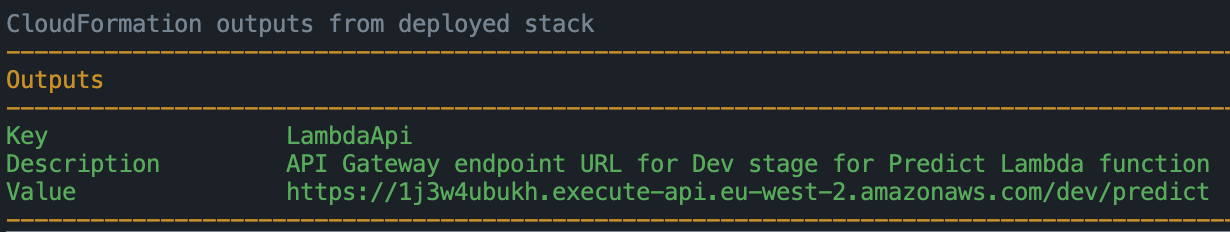

Accuracy: 0.95725


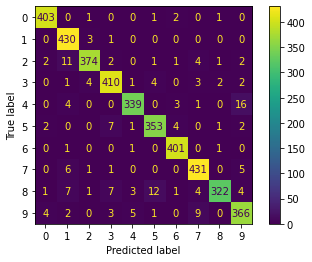

In [23]:
data = {
    'bucket':bucket_name,
    'key':key,
}

headers = {
    'Content-type': "application/json"
}

# Main code for post HTTP request
url = "https://qjiim4z1db.execute-api.eu-west-2.amazonaws.com/dev/predict"
response = requests.request("POST", url, headers=headers, json=data)
lambda_predictions = np.array(response.json())
show_cm(test_target, lambda_predictions, range(10))


- SAM will upload the latest build of your application onto a managed Amazon Elastic Container Registry (Amazon ECR) during the deployment phase.

- SAM will also output a list of CloudFormation events detailing the deployment of the requested AWS resources for your application.



# Delete your lambda function
<hr style = "border:2px solid black" ></hr>


- To terminate and delete AWS lambda functions: `sam delete --stack-name [NAME_OF_STACK]`
- Replace `[NAME_OF_STACK]` with the name of your application.



# References
<hr style = "border:2px solid black" ></hr>


- [Blog post](https://towardsdatascience.com/serverless-deployment-of-machine-learning-models-on-aws-lambda-5bd1ca9b5c42)
- [Github code](https://github.com/lloydhamilton/aws_lambda_no_authoriser)
- [Poetry for Python Virtual Environments](https://towardsdatascience.com/serverless-deployment-of-machine-learning-models-on-aws-lambda-5bd1ca9b5c42)

